# ConvNext Based Feature Extraction and Gradient Computation

## Setup

In [2]:
!pip install azure-storage-blob azure-identity --quiet
!pip install tensorflow-io --quiet

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/harvard.dce.nasa.cloud2cloud

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/harvard.dce.nasa.cloud2cloud


In [4]:
from google.colab import userdata
import os

account_name = userdata.get('storage_account_name')
account_key = userdata.get('storage_account_key')
container_name = userdata.get('blob_container_name')

os.environ['TF_AZURE_STORAGE_KEY'] = account_key

In [5]:
from azure.storage.blob import BlobServiceClient
import pandas as pd

# more info https://learn.microsoft.com/en-us/python/api/overview/azure/storage-blob-readme?view=azure-python
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

# setup to load file from blob
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [6]:
!ls -ltr

total 4230912
-rw------- 1 root root    6353641 Aug 23 14:54  IWG1.12May2017-2104.txt
-rw------- 1 root root      71771 Aug 23 14:54  Lens_1.4mm_62273_spec.pdf
-rw------- 1 root root 4194105190 Aug 23 15:00  170512_164101_171715.avi
-rw------- 1 root root     356043 Aug 23 15:01  goesrplt_CPL_layers_17934_20170512.txt
-rw------- 1 root root        596 Aug 24 07:12  nasa_cloud2cloud.ipynb
-rw------- 1 root root     921582 Aug 25 05:00  goesrpltcpl_dataset.pdf
drwx------ 2 root root       4096 Aug 25 05:58  images_170512
-rw------- 1 root root     348648 Aug 25 15:30  Seperating_Video_Frames_and_adjusting_contrast_brightness.ipynb
-rw------- 1 root root      93312 Aug 25 19:44  er2_metadata_processed_170512_164101_171715.csv
-rw------- 1 root root     129166 Sep  1 06:04  output.jpg
drwx------ 2 root root       4096 Sep  1 09:01  processed_images_179512
-rw------- 1 root root  111957084 Sep  1 09:16  model_checkpoint.pth
-rw------- 1 root root      54794 Sep 15 02:22  Attention_Layer12_H

## Image Processing and ConvNext feature extraction

In [7]:
%cd capstone_2024/cloud_features_tracking/
import cloud2cloud_ConvNext as CN

/content/drive/MyDrive/harvard.dce.nasa.cloud2cloud/capstone_2024/cloud_features_tracking


In [ ]:
images = [
    "20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg",
    "20170418/170418_175706_183328_frames/20170418_175707_frame_60.jpg",
    "20170418/170418_175706_183328_frames/20170418_175708_frame_120.jpg",
    "20170418/170418_175706_183328_frames/20170418_175709_frame_180.jpg",
    "20170418/170418_175706_183328_frames/20170418_175710_frame_240.jpg",
]

CN.visualize_augmentations_cv(images, account_name, container_name, container_client, True, True, use_tf=False)

SyntaxError: unterminated string literal (detected at line 13) (<ipython-input-2-df6aa30d0402>, line 13)

[[494.11764706   0.         960.        ]
 [  0.         494.11764706 540.        ]
 [  0.           0.           1.        ]]
494.1176470588235 494.11764705882354


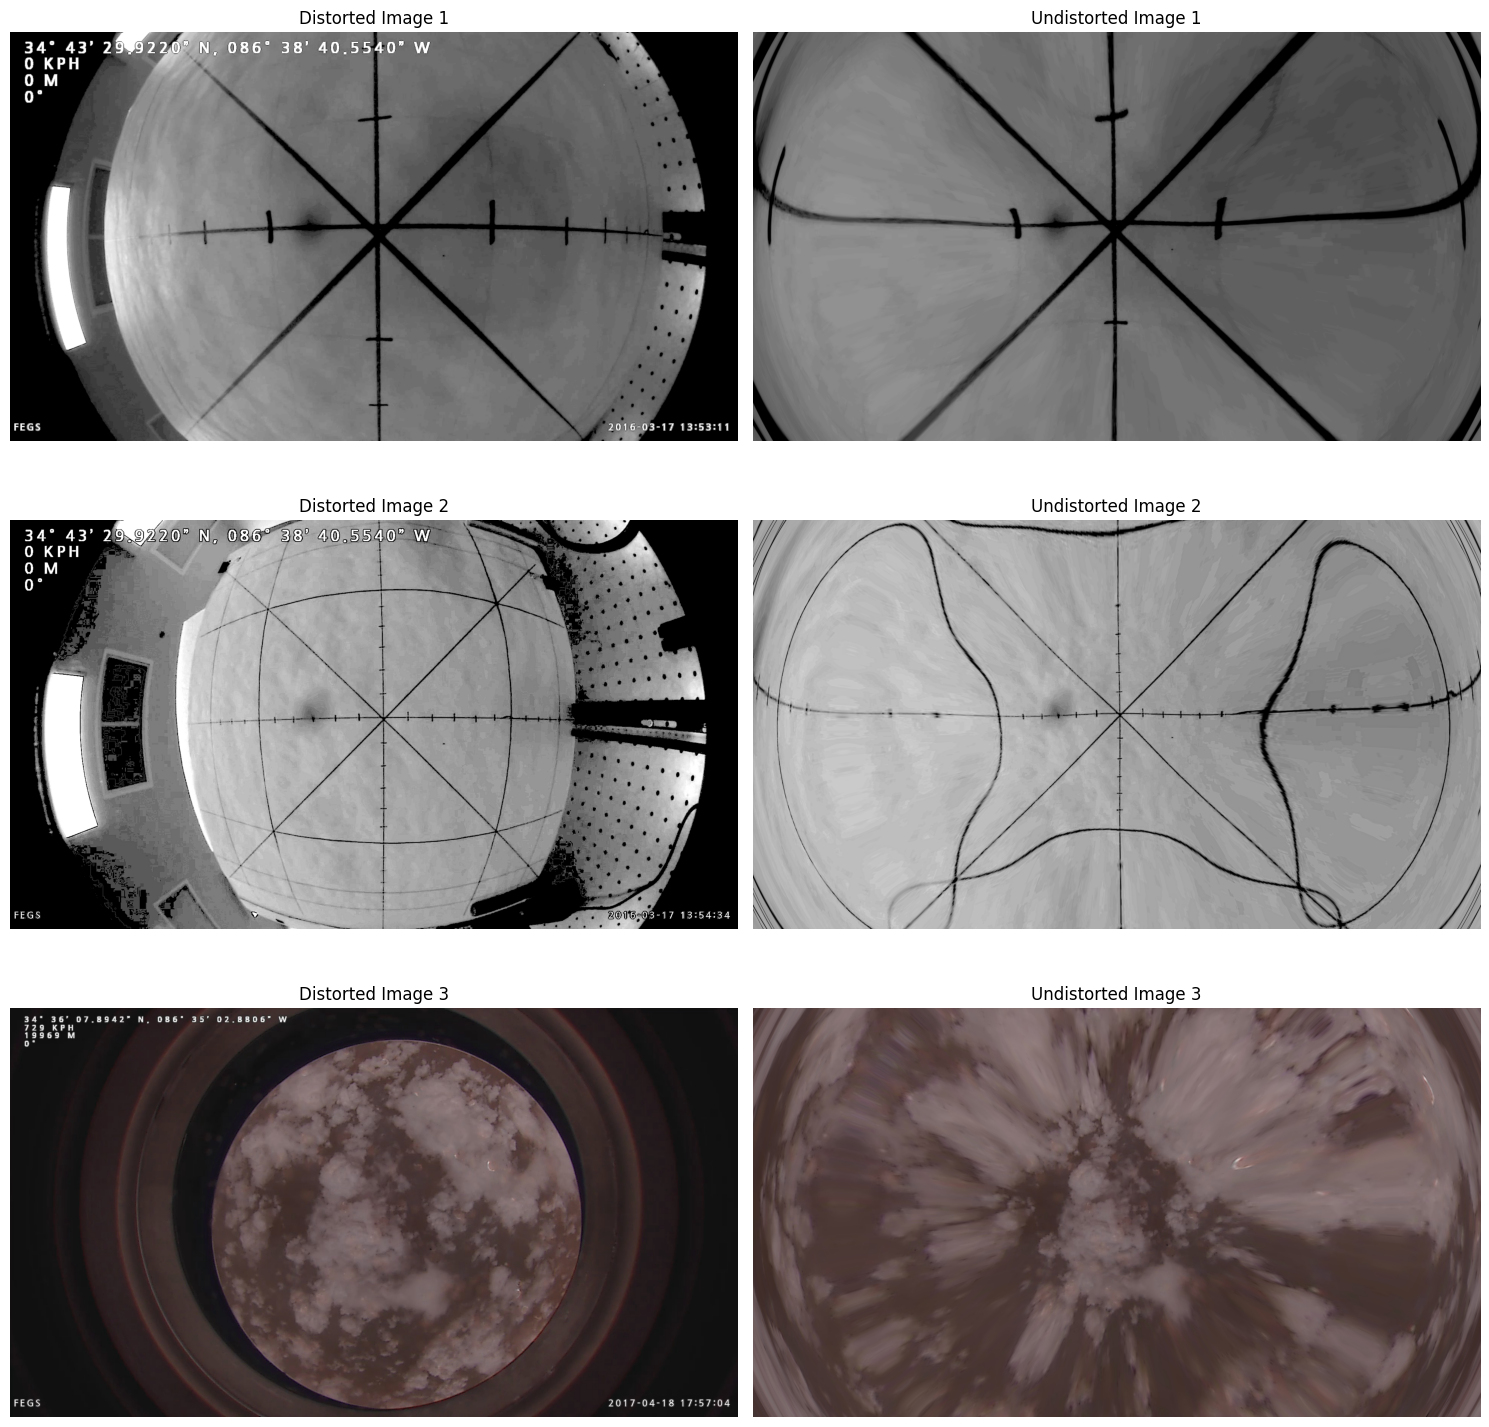

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the provided images
image_1_path = '8.tiff'
image_2_path = '24.tiff'

# Read the tiff images
distorted_image1 = cv2.imread(image_1_path, cv2.IMREAD_UNCHANGED)
distorted_image2 = cv2.imread(image_2_path, cv2.IMREAD_UNCHANGED)
distorted_image3 = CN.load_image_from_blob_cv("20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg", container_client)

# Parameters provided from NASA
f = 1.4  # Focal length in mm
W = 1920  # Image width in pixels
H = 1080  # Image height in pixels
# sw = 6.4  # Sensor width in mm derived from 1/2 inch Maximum Camera Sensor Format of Lens per pdf provided
# sh = 4.8  # Sensor height in mm derived from 1/2 inch Maximum Camera Sensor Format of Lens per pdf provided
sw = 5.44
sh = 3.06


# Calculate fx and fy
fx = (f * W) / sw  # (focal length of lens in mm * Image width in pixels) / Sensor width in mm
fy = (f * H) / sh  # (focal length of lens in mm * Image height in pixels) / Sensor height in mm
cx = W // 2  # Assuming the center is the middle of the image
cy = H // 2  # Assuming the center is the middle of the image

# Intrinsic matrix K
K = np.array([[fx, 0,  cx],
              [0,  fy, cy],
              [0,  0,   1]])

print(K)

print(fx, fy)

# Distortion coefficients provided by NASA
D = np.array([2.6684, -10.9170, 13.9753, -5.9015])

# Knew = K i.e. alpha = 1 to preserve scaling and perspective,
# alpha < 1, i.e. zoomes out and less stretching
# alpha > 1, zoomed in and more stretching
alpha = 1
Knew = np.array([[alpha*fx, 0,        cx],
                 [0,        alpha*fy, cy],
                 [0,        0,         1]])
new_size = (W, H)

undistorted_image1 = cv2.fisheye.undistortImage(distorted_image1, K, D, Knew=Knew, new_size=new_size)
undistorted_image2 = cv2.fisheye.undistortImage(distorted_image2, K, D, Knew=Knew, new_size=new_size)
undistorted_image3 = cv2.fisheye.undistortImage(distorted_image3, K, D, Knew=Knew, new_size=new_size)

distorts = [distorted_image1, distorted_image2, distorted_image3]
undistorts = [undistorted_image1, undistorted_image2, undistorted_image3]

fig, axes = plt.subplots(len(distorts), 2, figsize=(15, 15))

for i, image in enumerate(distorts):
    axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f'Distorted Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cv2.cvtColor(undistorts[i], cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title(f'Undistorted Image {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


intrinsic matrix output image:
 [[5.0000e+02 0.0000e+00 1.8855e+03]
 [0.0000e+00 5.0000e+02 1.0595e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
intrinsic matrix output image:
 [[5.0000e+02 0.0000e+00 1.8855e+03]
 [0.0000e+00 5.0000e+02 1.0595e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
intrinsic matrix output image:
 [[5.0000e+02 0.0000e+00 1.9195e+03]
 [0.0000e+00 5.0000e+02 1.0795e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


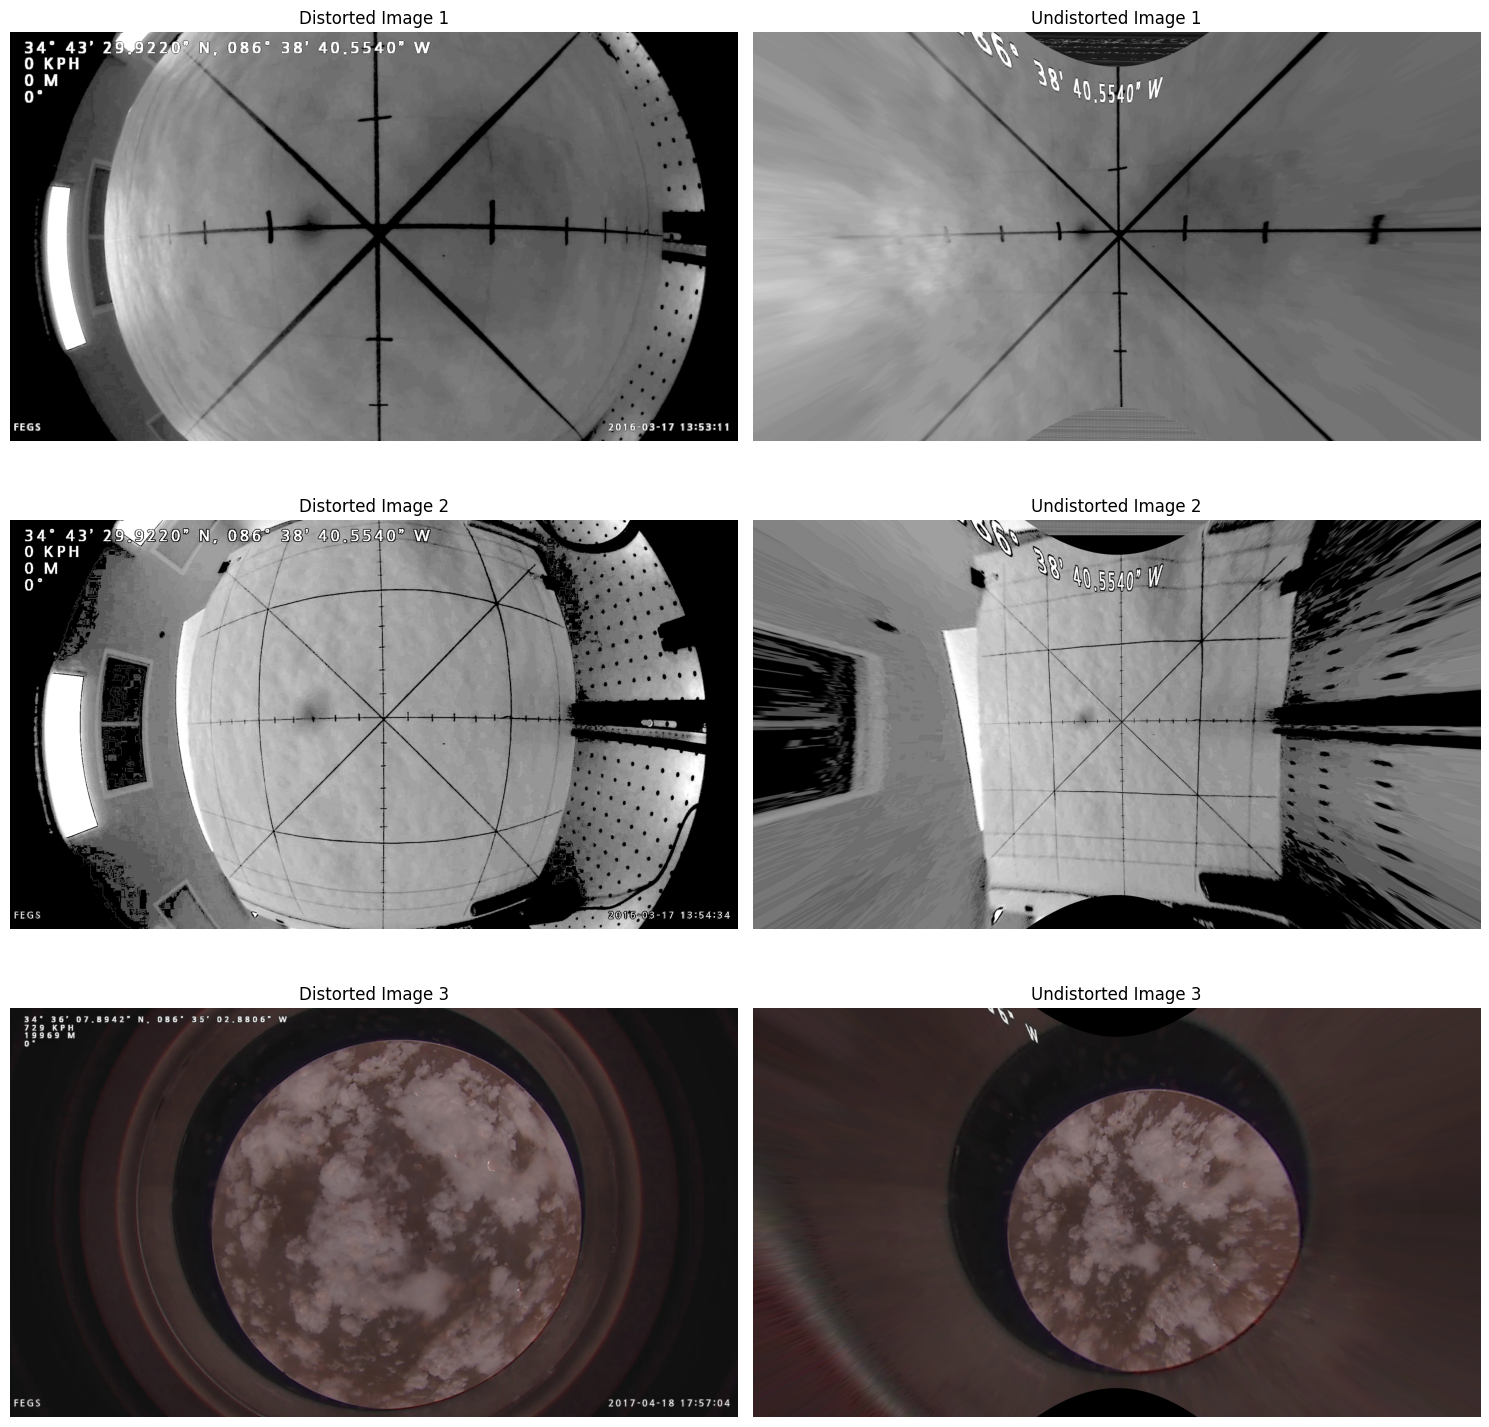

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
### Correction provided by Dr. Quick
image_1_path = '8.tiff'
image_2_path = '24.tiff'

distorted_image1 = cv2.imread(image_1_path, cv2.IMREAD_UNCHANGED)
distorted_image2 = cv2.imread(image_2_path, cv2.IMREAD_UNCHANGED)
distorted_image3 = CN.load_image_from_blob_cv("20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg", container_client)

distorts = [distorted_image1, distorted_image2, distorted_image3]
undistorts = []

f = 1.4     # focal length [mm]
mu = 2.8e-3 # pixel pitch [mm]
S = 2       # output (undistorted) image scale factor
#distortion polynomial order:  [2 4 6 8]
#polynomial coefficients:
coeffs = np.array([0.01166363, -0.04819808, 0.07918044, -0.037572])

for img in distorts:
    H = img.shape[0]    # image height [pixel]
    W = img.shape[1]    # image width [pixel]
    cx = (W-1)/2        # image center coordinate [pixel]
    cy = (H-1)/2        # image center coordinate [pixel]

    K = np.array([[f/mu,0,cx],[0,f/mu,cy],[0,0,1]])

    # compute intrinsic matrix for ouput image
    cpx = (W*S-1)/2
    cpy = (H*S-1)/2
    P = np.array([[f/mu,0,cpx],[0,f/mu,cpy],[0,0,1]])
    print('intrinsic matrix output image:\n',P)

    # rectification matrix (idenity)
    R = np.eye(3)
    # produce undistorted image
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K=K, D=coeffs, R=R, P=P, size=[W*S,H*S], m1type=cv2.CV_16SC2)
    udimg = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    undistorts.append(udimg)

fig, axes = plt.subplots(len(distorts), 2, figsize=(15, 15))

for i, image in enumerate(distorts):
    axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f'Distorted Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cv2.cvtColor(undistorts[i], cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title(f'Undistorted Image {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

(2120, 3772)
(2120, 3772)
(2160, 3840, 3)


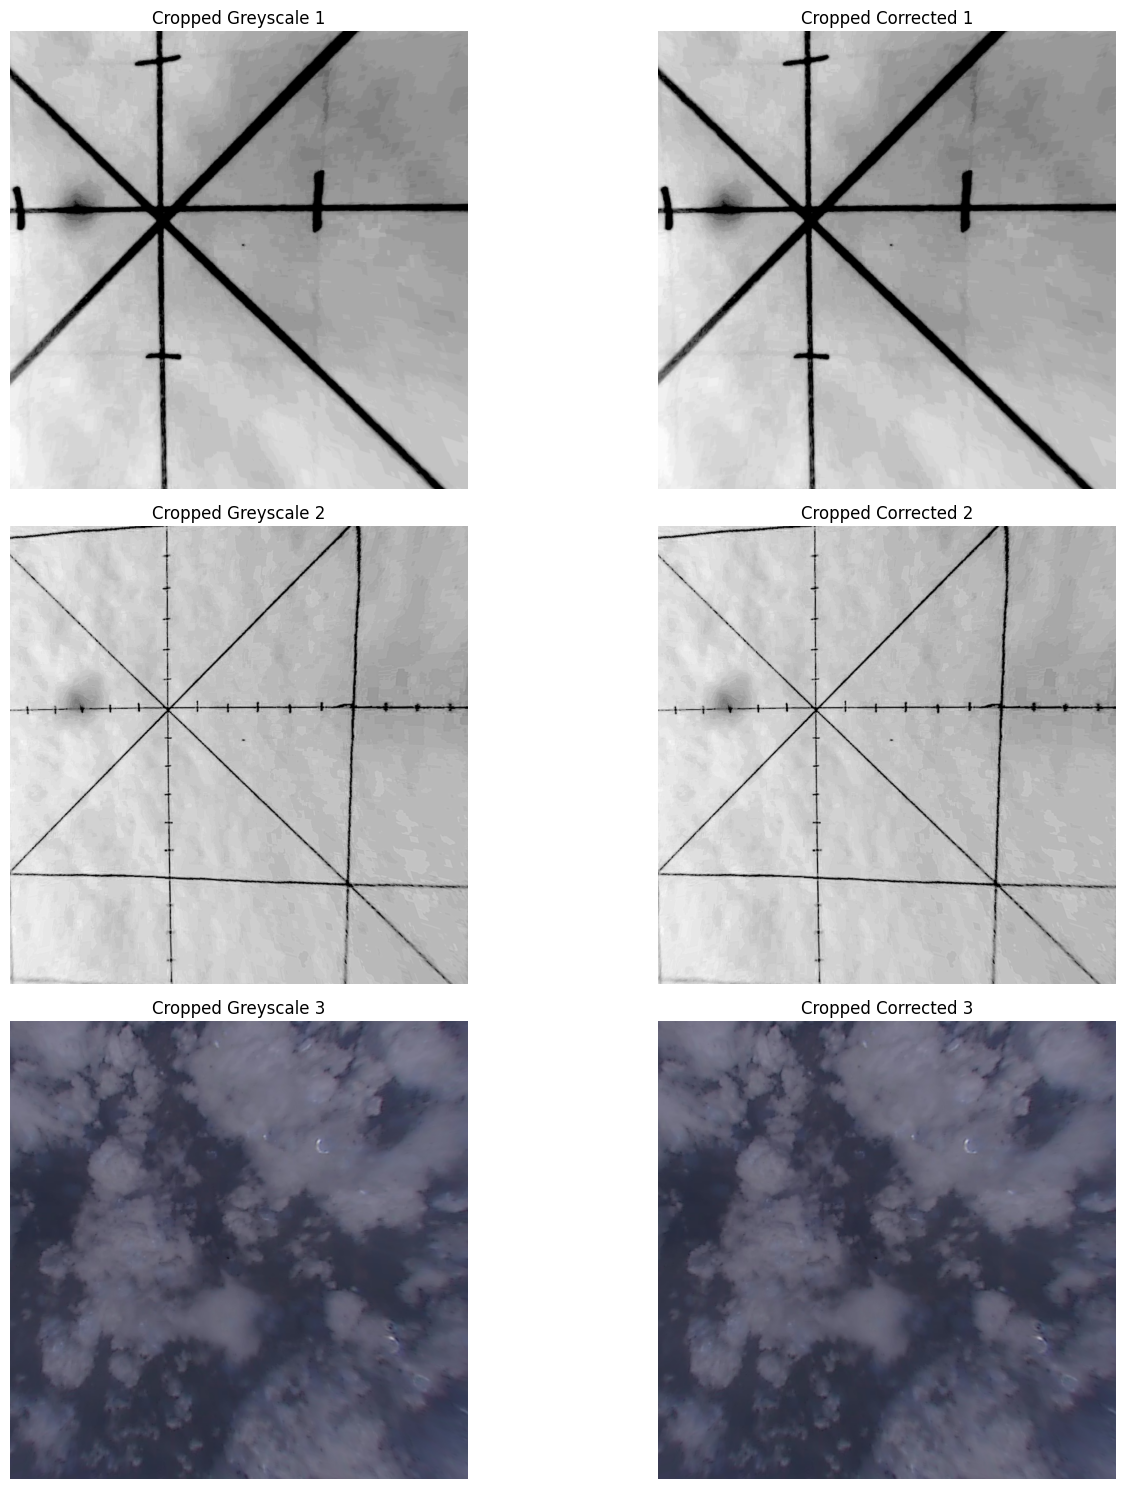

In [ ]:
def combined_crop_image_cv(image, size1=(1500, 1500), offset=(85, 180), size2=(1000, 1000)):
    h, w = image.shape[:2]

    # Cropping it to 1500X1500 and accounting for offset.
    center_h, center_w = h // 2, w // 2
    offset_h, offset_w = offset
    start_h = min(max(center_h - size1[0] // 2 + offset_h, 0), h - size1[0])
    start_w = min(max(center_w - size1[1] // 2 + offset_w, 0), w - size1[1])
    cropped_image = image[start_h:start_h + size1[0], start_w:start_w + size1[1]]
    h, w = cropped_image.shape[:2]

    # further crop the image to 1000X1000
    center_h, center_w = h // 2, w // 2
    start_h = max(center_h - size2[0] // 2, 0)
    start_w = max(center_w - size2[1] // 2, 0)

    return cropped_image[start_h:start_h + size2[0], start_w:start_w + size2[1]]


cropped_greyscale = []
corr_imgs = []
for img in undistorts:
    print(img.shape)
    # greyscale_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    corrected_image = combined_crop_image_cv(img, size1=(1500, 1500), offset=(85, 180), size2=(1000, 1000))
    # cropped_greyscale.append(greyscale_image)
    corr_imgs.append(corrected_image)

fig, axes = plt.subplots(len(distorts), 2, figsize=(15, 15))

for i, image in enumerate(corr_imgs):
    axes[i, 0].imshow(corr_imgs[i], cmap=plt.get_cmap('gray'))
    axes[i, 0].set_title(f'Cropped Greyscale {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(corr_imgs[i], cmap=plt.get_cmap('gray'))
    axes[i, 1].set_title(f'Cropped Corrected {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
from skimage.filters.rank import equalize, threshold
from skimage import exposure
from skimage.morphology import disk, square
import cv2
import numpy as np
from matplotlib import pyplot as plt


def augment_greyscale_image(img, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=True):
    """
    Augments the Greyscale image to enhance the feature of the cloud. Includes:
      1. Contrast and Brightness
      2. Gaussian Blur
      3. Histogram Equalization
      4. Sharpening
    Args:
        img (numpy.ndarray): greyscale image
        contrast_factor (float): contrast factor
        brightness_beta (int): brightness factor
        kernel_size (tuple): kernel size for Gaussian Blur
        blur (bool): whether to apply Gaussian Blur
    Returns:
        (numpy.ndarray): augmented image
    """
    img_enhanced = cv2.convertScaleAbs(img, alpha=contrast_factor, beta=brightness_beta)
    # if blur:
    #     img_enhanced = cv2.GaussianBlur(img_enhanced, kernel_size, 0)
    img_enhanced = exposure.equalize_adapthist(img_enhanced)
    # img_enhanced = cv2.equalizeHist(img_enhanced)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # img_enhanced = clahe.apply(img_enhanced)
    # img_enhanced = equalize(np.multiply(img_enhanced, 255).astype(np.uint8), footprint=disk(9))
    # kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    # img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)
    return img_enhanced

import cv2
import numpy as np

def augment_greyscale_image_adaptive(img, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=True):
    """
    Dynamically augments greyscale images while preserving features for high-brightness (white) regions.
    Includes:
      1. Adaptive Contrast and Brightness
      2. Gaussian Blur
      3. Conditional Histogram Equalization
      4. Sharpening
    Args:
        img (numpy.ndarray): greyscale image
        contrast_factor (float): default contrast factor
        brightness_beta (int): default brightness factor
        kernel_size (tuple): kernel size for Gaussian Blur
        blur (bool): whether to apply Gaussian Blur
    Returns:
        numpy.ndarray: augmented image
    """
    # Analyze image brightness
    mean_intensity = np.mean(img)

    # Dynamically scale contrast and brightness for bright images
    if mean_intensity > 200:  # Very bright image
        contrast_factor = 1.2  # Reduce contrast
        brightness_beta = 10  # Reduce brightness increment
    elif mean_intensity < 50:  # Very dark image
        contrast_factor = 1.8  # Increase contrast
        brightness_beta = 40  # Increase brightness increment

    # Step 1: Contrast and Brightness adjustment
    img_enhanced = cv2.convertScaleAbs(img, alpha=contrast_factor, beta=brightness_beta)

    # Step 2: Apply Gaussian Blur if requested
    if blur:
        img_enhanced = cv2.GaussianBlur(img_enhanced, kernel_size, 0)

    # Step 3: Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_enhanced)

    # Step 4: Apply sharpening only if not too bright
    if mean_intensity < 230:  # Avoid sharpening overly white images
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)

    return img_enhanced



def plot_grayscale(img):
    fig, ax = plt.subplots( figsize=(6, 6))
    _=ax.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()


def plot_gray_scale_distribution(img):
    '''Function plots histograms a gray scale image along
    with the cumulative distribution'''
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(img.flatten(), bins=50, density=True, alpha=0.3)
    ax[0].set_title('Histogram of image')
    ax[0].set_xlabel('Pixel value')
    ax[0].set_ylabel('Density')

    ax[1].hist(img.flatten(), bins=50, density=True, cumulative=True, histtype='step')
    ax[1].set_title('Cumulative distribution of image')
    ax[1].set_xlabel('Pixel value')
    ax[1].set_ylabel('Cumulative density')
    plt.show()

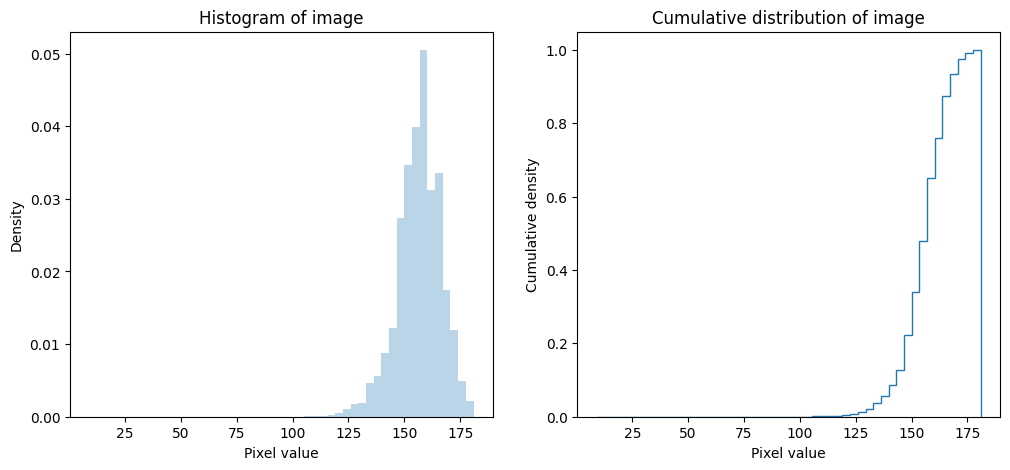

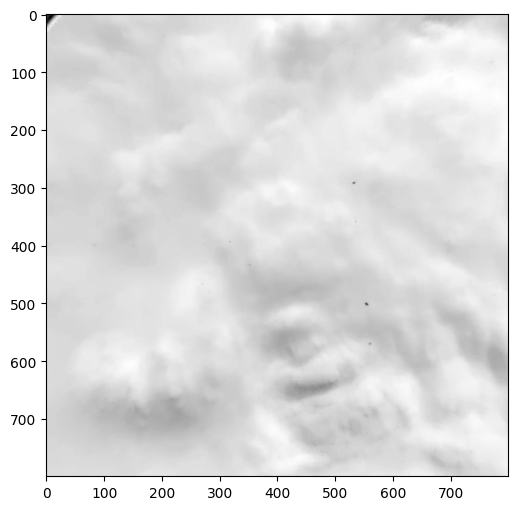

In [12]:
original_image = CN.load_image_from_blob_cv("20170508/170508_230135_233759_frames_crop_corrected_aligned/20170508_230839_frame_25440.jpg", container_client)
greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
plot_gray_scale_distribution(greyscale_image)
plot_grayscale(greyscale_image)

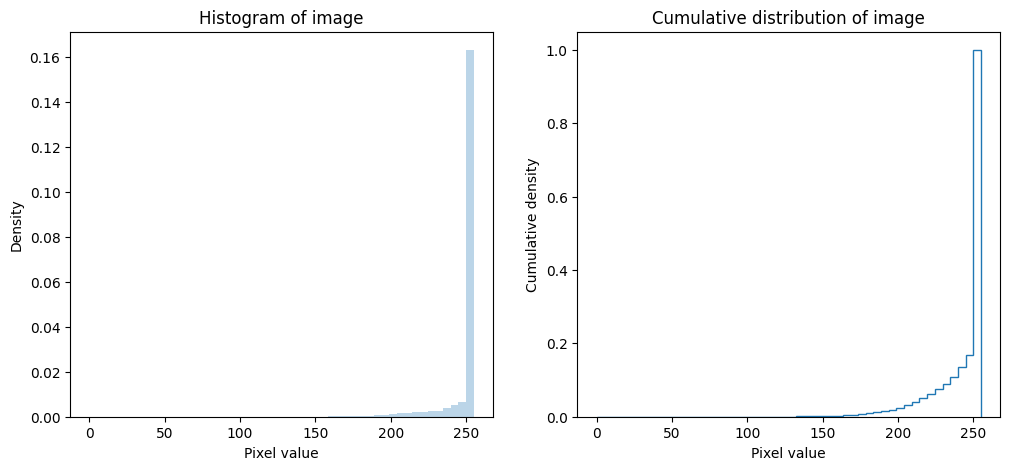

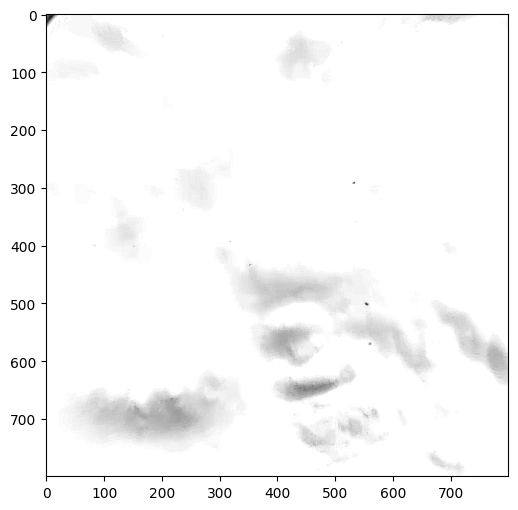

In [13]:
augmented_image = augment_greyscale_image_adaptive(greyscale_image, blur=False)
plot_gray_scale_distribution(augmented_image)
plot_grayscale(augmented_image)

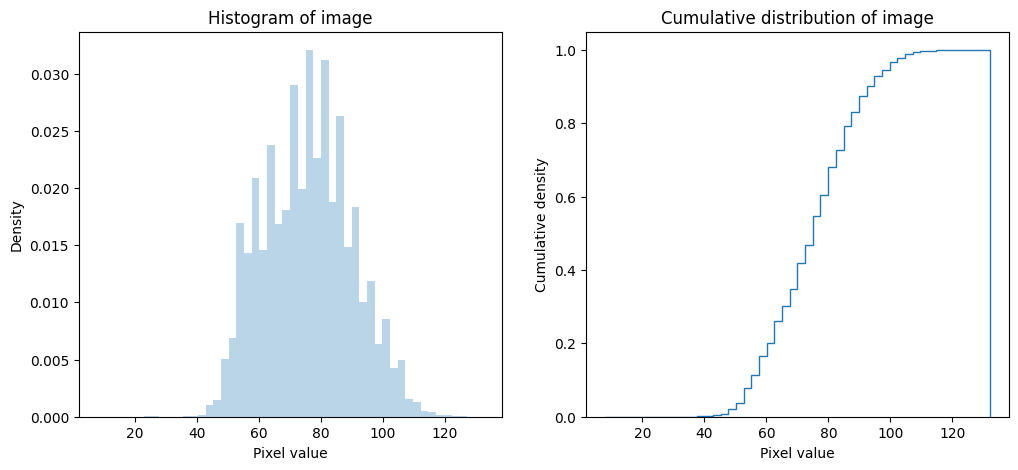

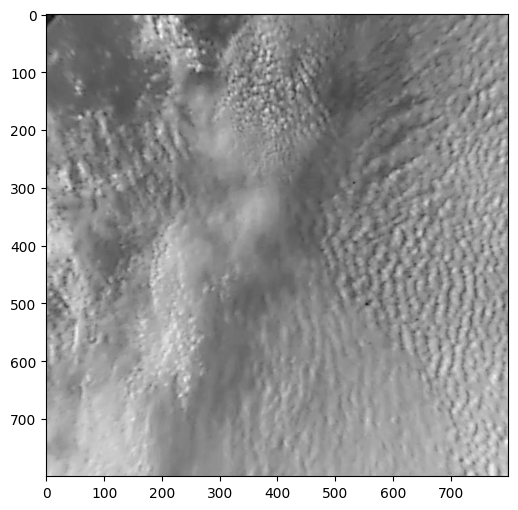

In [ ]:

images2 = ["20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115518_frame_0.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115519_frame_60.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/0170514_115520_frame_120.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115521_frame_180.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115522_frame_240.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115523_frame_300.jpg"
]
original_image = CN.load_image_from_blob_cv(images2[5], container_client)
greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
plot_gray_scale_distribution(greyscale_image)
plot_grayscale(greyscale_image)

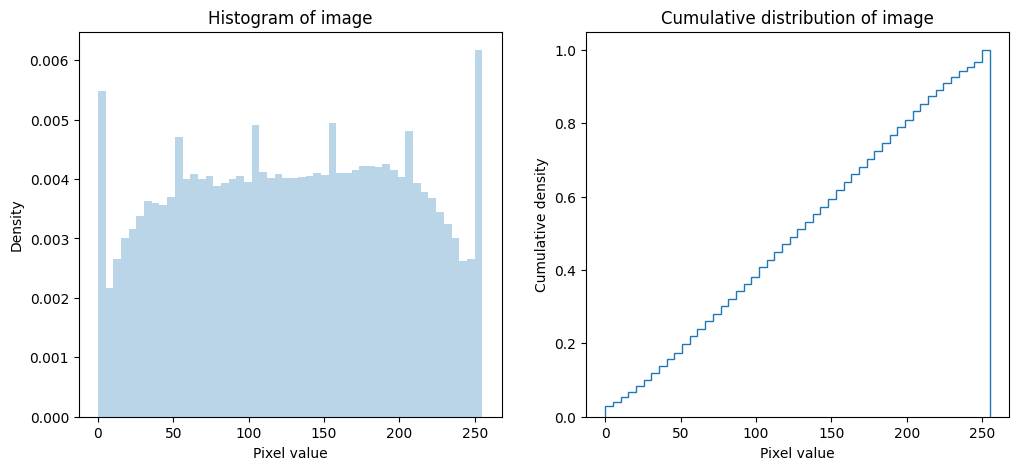

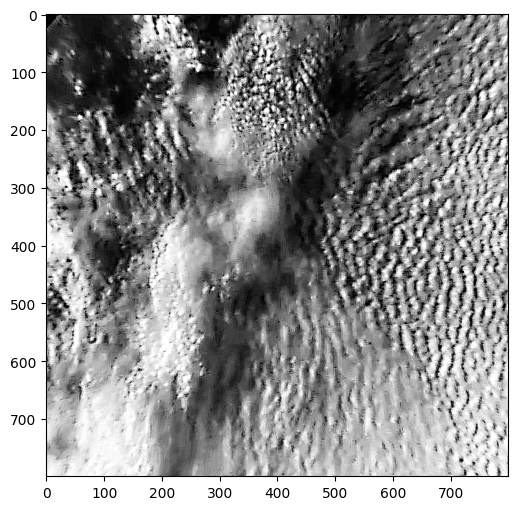

In [ ]:
augmented_image = augment_greyscale_image_adaptive(greyscale_image)
plot_gray_scale_distribution(augmented_image)
plot_grayscale(augmented_image)

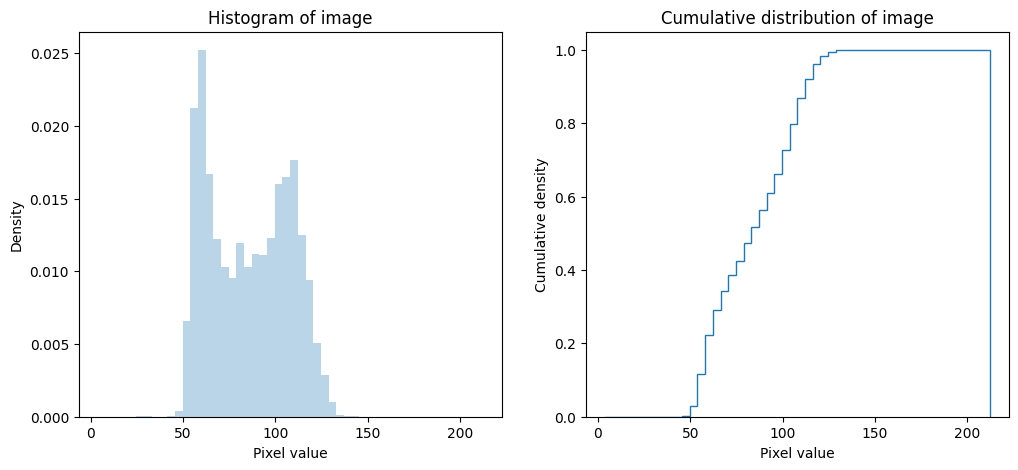

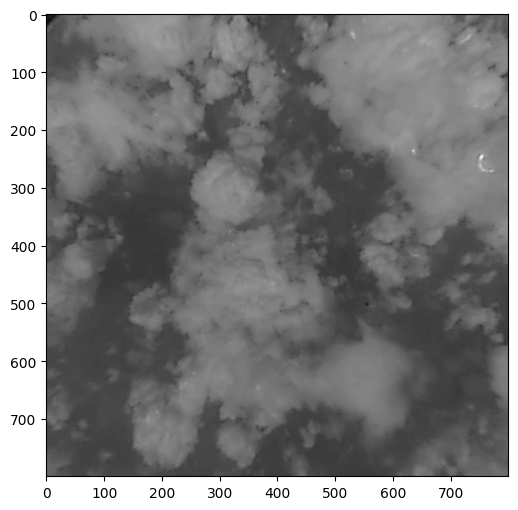

In [ ]:
original_image = CN.load_image_from_blob_cv("20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg", container_client)
greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
fisheye_corrected_image = CN.undistort_fisheye_image(grayscale_image)
cropped_image = CN.crop_and_correct_image_cv2(fisheye_corrected_image)
plot_gray_scale_distribution(cropped_image)
plot_grayscale(cropped_image)

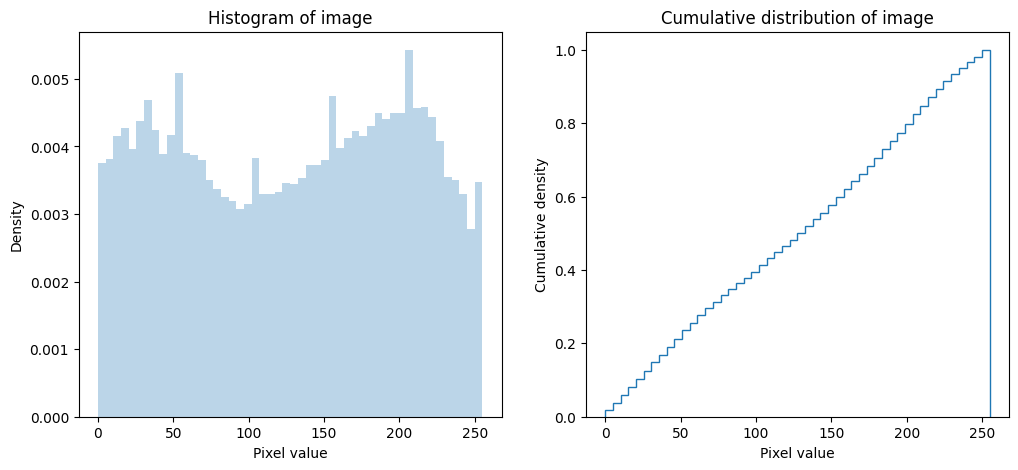

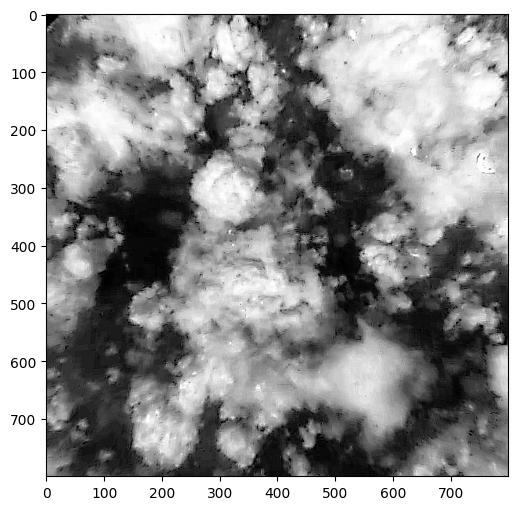

In [ ]:
augmented_image = CN.augment_greyscale_image(cropped_image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=False)
plot_gray_scale_distribution(augmented_image)
plot_grayscale(augmented_image)

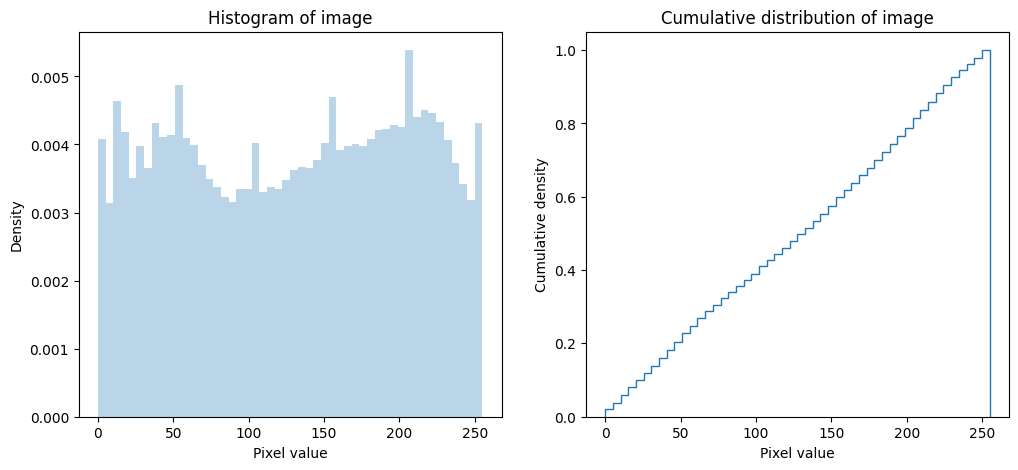

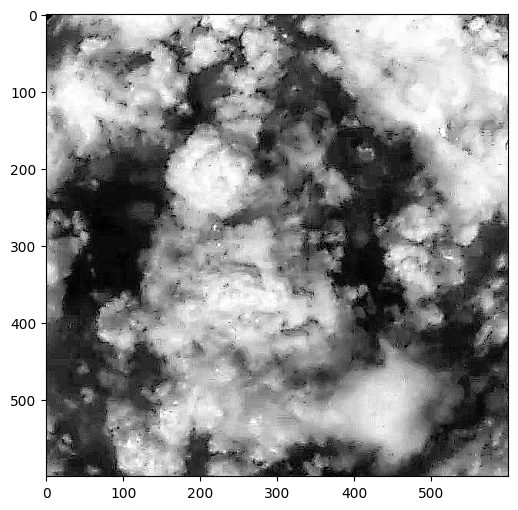

In [ ]:
augmented_image2 = CN.augment_greyscale_image(greyscale_image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=False)
plot_gray_scale_distribution(augmented_image2)
plot_grayscale(augmented_image2)

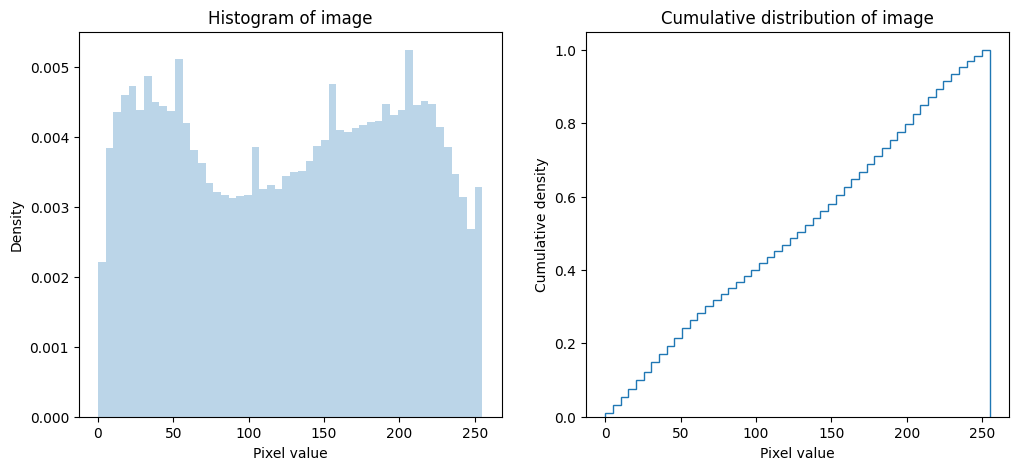

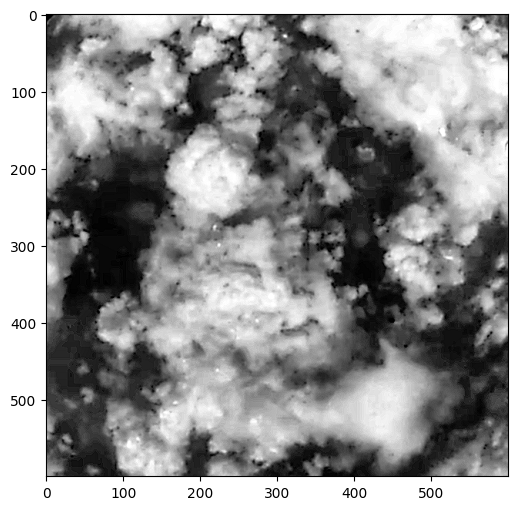

In [ ]:
augmented_image2 = CN.augment_greyscale_image(greyscale_image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=True)
plot_gray_scale_distribution(augmented_image2)
plot_grayscale(augmented_image2)


For gamma = 0.5


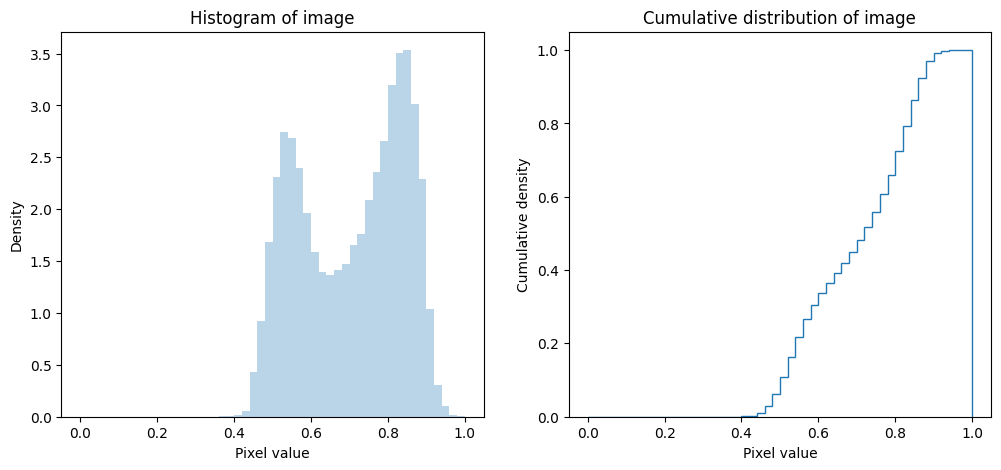


For gamma = 0.75


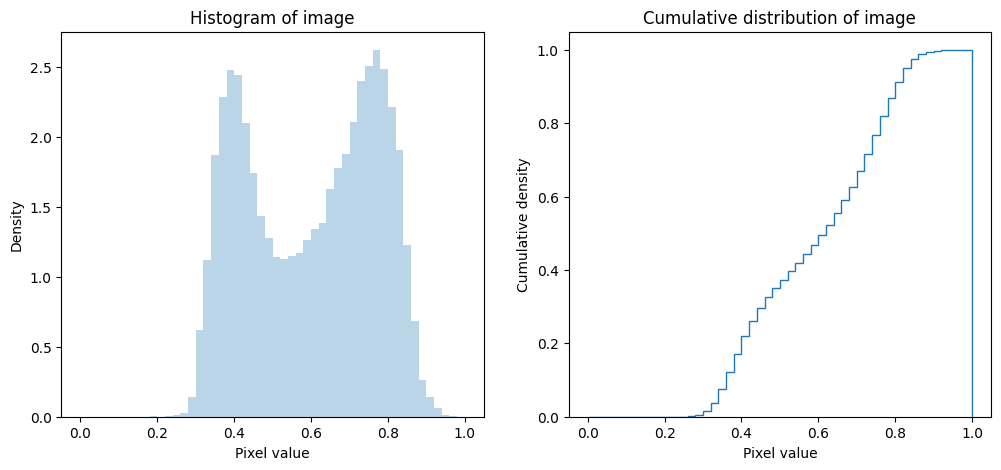


For gamma = 1


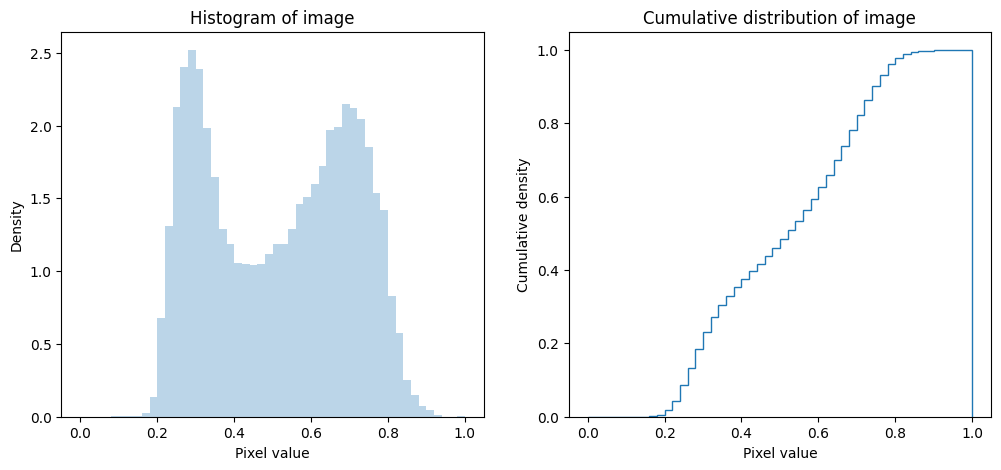


For gamma = 1.5


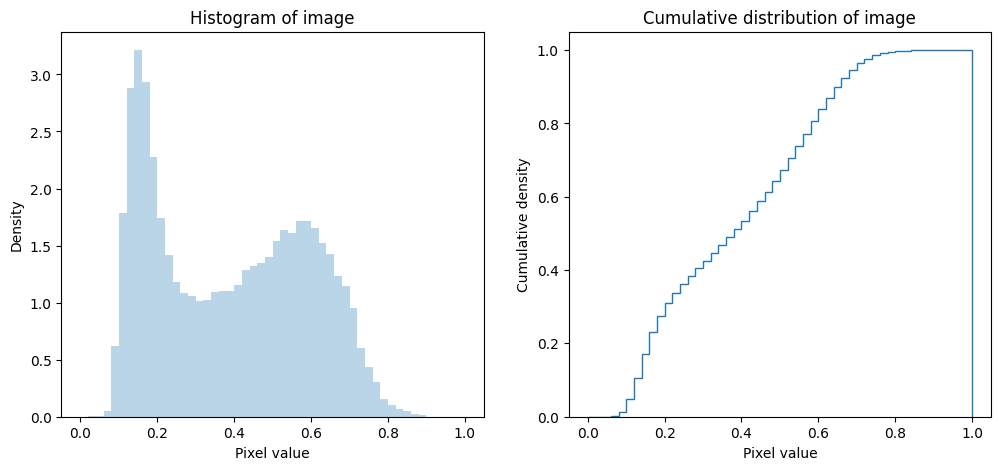


For gamma = 2.0


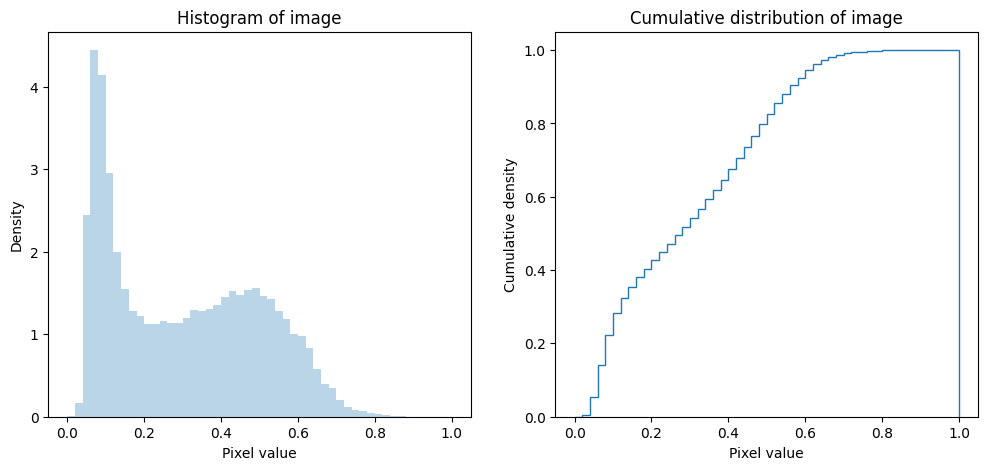

In [ ]:
import skimage
from skimage import exposure

for gamma in [0.5,0.75,1,1.5,2.0]:
    print("\nFor gamma = " + str(gamma))
    gamma_corrected_image = exposure.adjust_gamma(augmented_image, gamma)
    plot_gray_scale_distribution(gamma_corrected_image)

For cutoff = 0.3


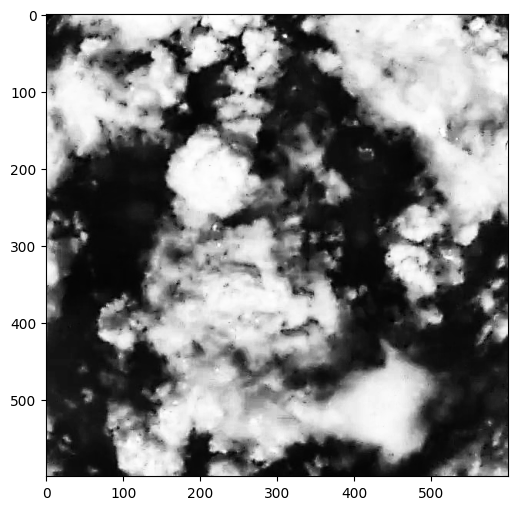

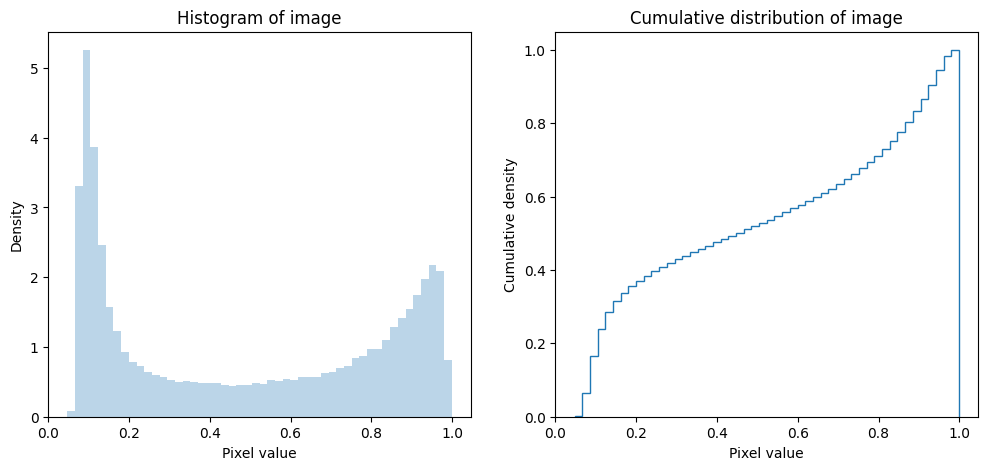

For cutoff = 0.4


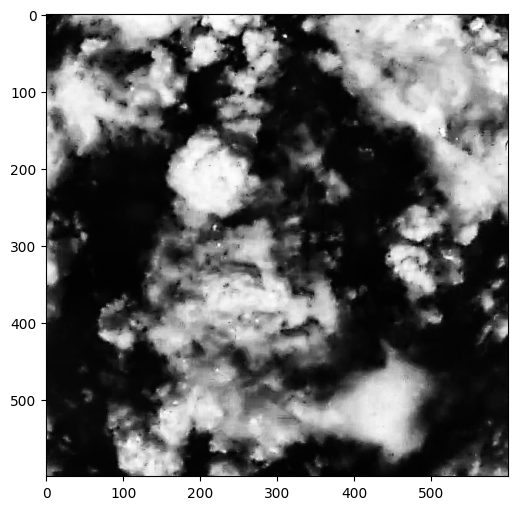

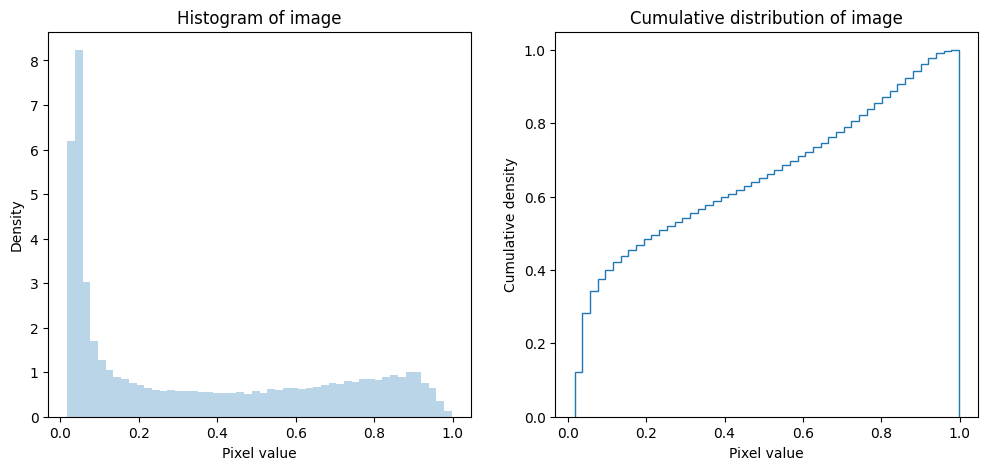

For cutoff = 0.5


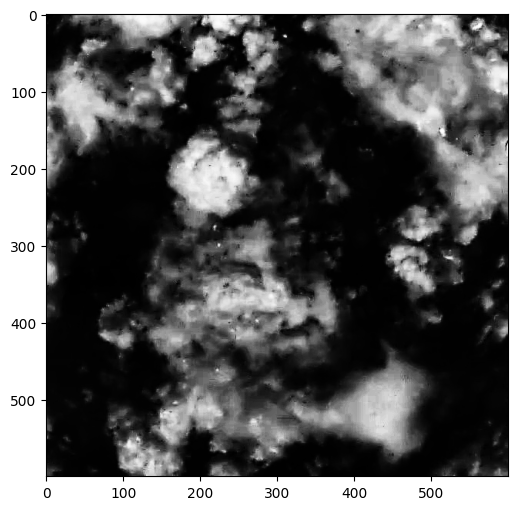

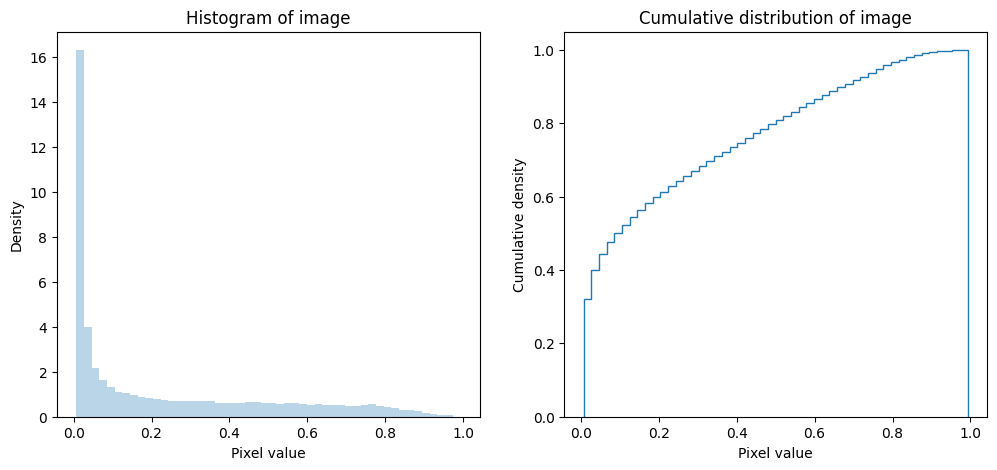

In [ ]:
for cutoff in [0.3,0.4,0.5]:
    gamma_corrected_image_sigmoid = exposure.adjust_sigmoid(gamma_corrected_image, cutoff=cutoff)
    print('For cutoff = ' + str(cutoff))
    plot_grayscale(gamma_corrected_image_sigmoid)
    plot_gray_scale_distribution(gamma_corrected_image_sigmoid)

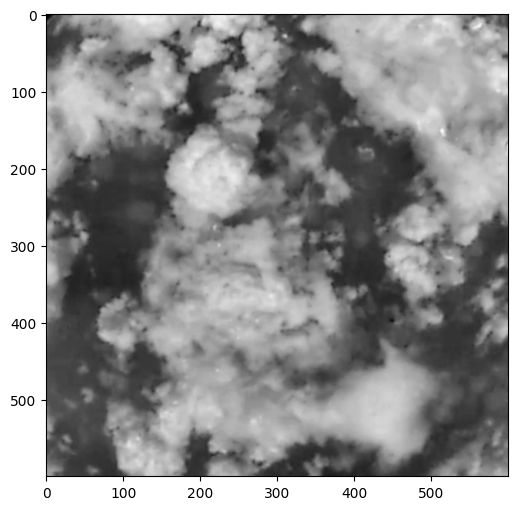

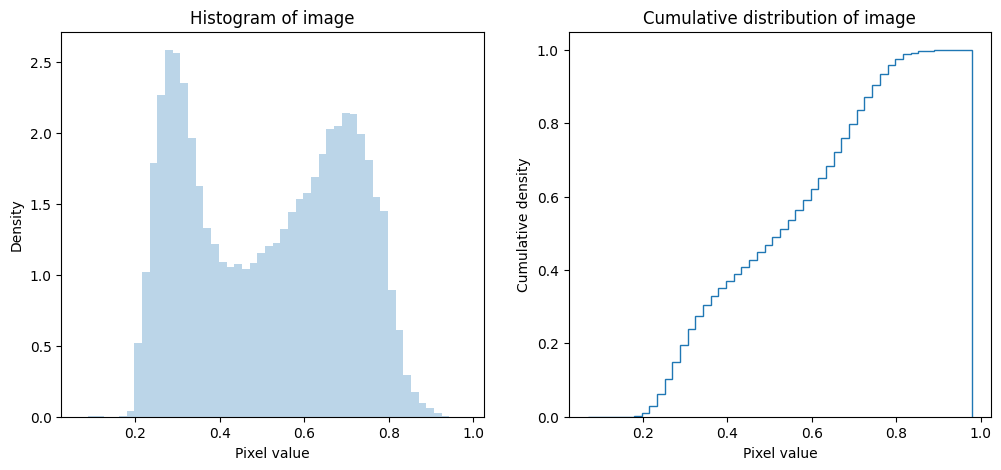

In [ ]:
import skimage.filters as skfilters
gamma_corrected_image = exposure.adjust_gamma(augmented_image, 1)
# gamma_corrected_image_sigmoid = exposure.adjust_sigmoid(gamma_corrected_image, cutoff=0.3)
gamma_corrected_image_sigmoid_gaussian = skfilters.gaussian(gamma_corrected_image, sigma=1)
plot_grayscale(gamma_corrected_image_sigmoid_gaussian)
plot_gray_scale_distribution(gamma_corrected_image_sigmoid_gaussian)

Gray-scale
(600, 600)


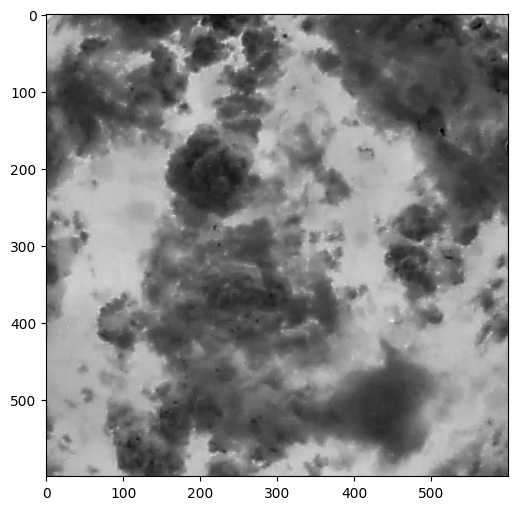

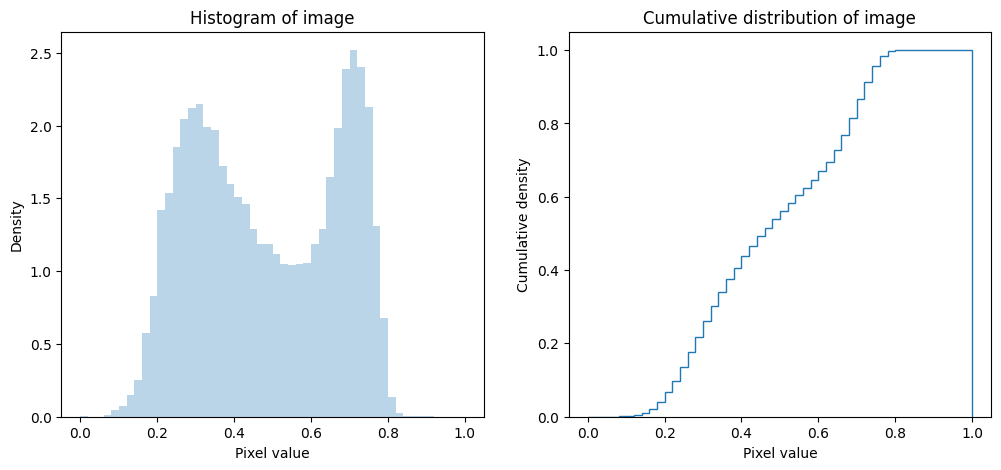

In [ ]:
## Put you code below
def invert_image(img):
    '''
    Function to invert an image, or create the negative.
        Args:
            img - a 2d gray scale or color image
        Returns:
            Inverse of the image
    '''
    ## Make sure to use a copy to prevent weird bugs that
    ## that are nearly impossible to track down
    img = np.copy(img)

    ## Put your code below
    if img.dtype == 'uint8': max_pixel_value = 255
    else: max_pixel_value = 1.0

    if len(img.shape) == 3: # Test for color image
        for i in range(3):
            img[:,:,i] = np.subtract(max_pixel_value, img[:,:,i])
            print('Color channel')
    else:
        img = np.subtract(max_pixel_value, img)
        print('Gray-scale')
    return img


inverted_augmented_image = invert_image(augmented_image)
print(inverted_augmented_image.shape)
plot_grayscale(inverted_augmented_image)
plot_gray_scale_distribution(inverted_augmented_image)

Gray-scale
(600, 600)


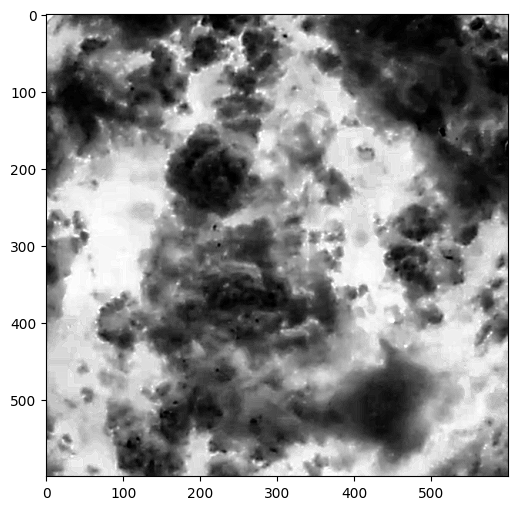

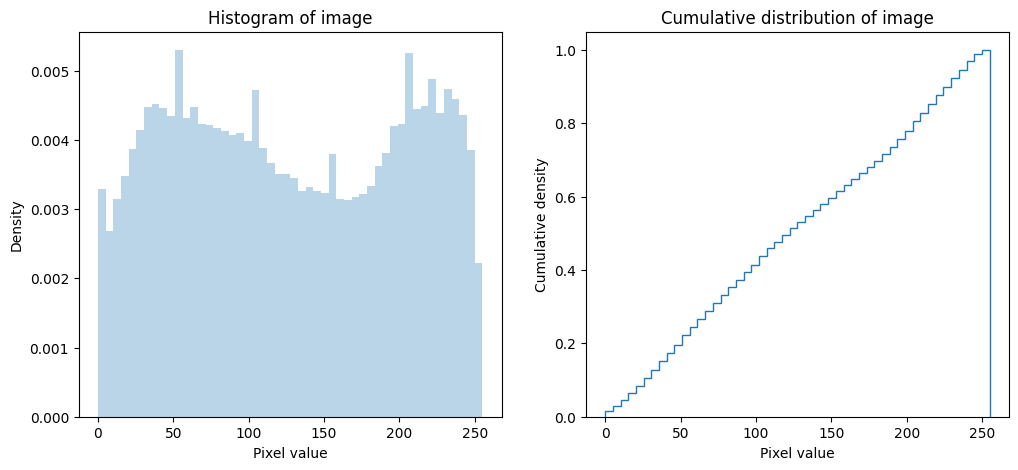

In [ ]:
inverted_augmented_image2 = invert_image(augmented_image2)
print(inverted_augmented_image2.shape)
plot_grayscale(inverted_augmented_image2)
plot_gray_scale_distribution(inverted_augmented_image2)

In [ ]:
from azure.storage.blob import BlobServiceClient
CN.visualize_augmentations_cv(images, account_name, container_name, container_client, True, True, use_tf=True)

In [ ]:
from transformers import AutoImageProcessor, ConvNextModel
from azure.storage.blob import BlobServiceClient


model_name = "facebook/convnext-tiny-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ConvNextModel.from_pretrained(model_name)

model.eval()

blob_img = "20170418/170418_175706_183328_frames_cropped/20170418_175706_frame_0_cropped.jpg"
feature_map = CN.extract_features(blob_img, image_processor, model, account_name, container_name, container_client, enhance=False, use_tf=False)
gradients = CN.extract_gradients(blob_img, image_processor, model, account_name, container_name, container_client, enhance=False, use_tf=False)

feature_map_enhance = CN.extract_features(blob_img, image_processor, model, account_name, container_name, container_client, enhance=True, use_tf=False)
gradients_enhance = CN.extract_gradients(blob_img, image_processor, model, account_name, container_name, container_client, enhance=True, use_tf=False)
# apply_regularization(model) not necessary unless fine-tuning

print(f"Feature Map Shape: {feature_map.shape}")
print(f"Feature Map Shape: {feature_map_enhance.shape}")
print(f"Gradients Shape: {gradients.shape}")
print(f"Gradients Shape: {gradients_enhance.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Feature Map Shape: torch.Size([1, 768, 7, 7])
Feature Map Shape: torch.Size([1, 768, 7, 7])
Gradients Shape: torch.Size([1, 3, 224, 224])
Gradients Shape: torch.Size([1, 3, 224, 224])


In [ ]:
# print(feature_map, gradients)

In [ ]:
images = [
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175706_frame_0.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175707_frame_60.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175708_frame_120.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175709_frame_180.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175710_frame_240.jpg",
]

models = [
    "facebook/convnext-tiny-224",
    "facebook/convnext-small-224",
    "facebook/convnext-base-224",
    "facebook/convnext-large-224"
]

CN.visualize_feature_maps(images, models, account_name, container_name, container_client, enhance=True, correct_fisheye=False, crop=False, overlay_grad=False, use_tf=False)
# CN.visualize_feature_maps(images, models, account_name, container_name, container_client, True, True, False, use_tf=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images2 = ["20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115518_frame_0.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115519_frame_60.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115520_frame_120.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115521_frame_180.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115522_frame_240.jpg",
           "20170514/170514_115518_123118_frames_crop_corrected_aligned/20170514_115523_frame_300.jpg"
]

CN.visualize_feature_maps(images2, models, account_name, container_name, container_client, enhance=True, correct_fisheye=False, crop=False, overlay_grad=False, use_tf=False)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
images3 = [
    "20170508/170508_214121_221716_frames_crop_corrected_aligned/20170508_221229_frame_112080.jpg",
    "20170508/170508_214121_221716_frames_crop_corrected_aligned/20170508_221230_frame_112140.jpg",
    "20170508/170508_214121_221716_frames_crop_corrected_aligned/20170508_221231_frame_112200.jpg",
    "20170508/170508_214121_221716_frames_crop_corrected_aligned/20170508_221232_frame_112260.jpg",
    "20170508/170508_214121_221716_frames_crop_corrected_aligned/20170508_221233_frame_112320.jpg",
    "20170508/170508_230135_233759_frames_crop_corrected_aligned/20170508_230839_frame_25440.jpg",
    "20170508/170508_230135_233759_frames_crop_corrected_aligned/20170508_230840_frame_25500.jpg",
    "20170508/170508_230135_233759_frames_crop_corrected_aligned/20170508_230841_frame_25560.jpg",
    "20170508/170508_230135_233759_frames_crop_corrected_aligned/20170508_230842_frame_25620.jpg",
    "20170508/170508_230135_233759_frames_crop_corrected_aligned/20170508_230843_frame_25680.jpg",
]


models = [
    "facebook/convnext-tiny-224",
    "facebook/convnext-small-224",
    "facebook/convnext-base-224",
    "facebook/convnext-large-224"
]

CN.visualize_feature_maps(images3, models, account_name, container_name, container_client, enhance=True, correct_fisheye=False, crop=False, overlay_grad=False, use_tf=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import AutoImageProcessor, ConvNextModel


def print_pixel_stats(stage, image):
    if isinstance(image, np.ndarray):
        print(f"{stage} - dtype: {image.dtype}, min: {image.min()}, max: {image.max()}, shape: {image.shape}")
    elif isinstance(image, torch.Tensor):
        print(f"{stage} - dtype: {image.dtype}, min: {image.min().item()}, max: {image.max().item()}, shape: {image.shape}")
    else:
        print(f"{stage} - dtype: {image.mode}, shape: {image.size}")
        print(f"{stage} - Pixel values range: {np.array(image).min()} to {np.array(image).max()}")


blob_img = "20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg"
original_image = CN.load_image_from_blob_cv(blob_img, container_client)
print_pixel_stats("Original Image", original_image)
grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
print_pixel_stats("Greyscale Image", grayscale_image)
fisheye_corrected_image = CN.undistort_fisheye_image(grayscale_image)
print_pixel_stats("Fisheye Corrected Image", fisheye_corrected_image)
cropped_image = CN.crop_and_correct_image_cv2(fisheye_corrected_image)
print_pixel_stats("Cropped Image", cropped_image)
augmented_image = CN.augment_greyscale_image(cropped_image)
print_pixel_stats("Augmented Image", augmented_image)
image_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_GRAY2RGB)
print_pixel_stats("Transformed Image (RGB)", image_rgb)
image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-large-224")
inputs = image_processor(image_rgb, return_tensors="pt")
print_pixel_stats("ConvNeXt Preprocessed Image", inputs['pixel_values'])


Original Image - dtype: uint8, min: 0, max: 255, shape: (1080, 1920, 3)
Greyscale Image - dtype: uint8, min: 0, max: 255, shape: (1080, 1920)
Fisheye Corrected Image - dtype: uint8, min: 0, max: 255, shape: (2160, 3840)
Cropped Image - dtype: uint8, min: 4, max: 212, shape: (800, 800)
Augmented Image - dtype: uint8, min: 0, max: 255, shape: (800, 800)
Transformed Image (RGB) - dtype: uint8, min: 0, max: 255, shape: (800, 800, 3)
ConvNeXt Preprocessed Image - dtype: torch.float32, min: -2.1179039478302, max: 2.640000104904175, shape: torch.Size([1, 3, 224, 224])


## Tracking points at the centre for == 5 seconds. at 12X12 center of the image. #WIP

In [ ]:
# Disclaimer: Work in Progress, this is just to put down the thought of automated point tracking
# It may need correction before actually working
# Refer the comments with the word 'Change'

import cv2
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from azure.storage.blob import BlobServiceClient
from PIL import Image
from transformers import ConvNextModel, AutoImageProcessor
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import tensorflow as tf
import tensorflow_io as tfio


image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-base-224")
model = ConvNextModel.from_pretrained("facebook/convnext-base-224")
model.eval()


def get_blob_filenames(blob_directory, container_client, use_tf=True):
    """Retrieve the list of filenames from a given blob directory."""
    if use_tf:
        print(f'az://{account_name}/{container_name}/{blob_directory}')
        blob_list = tf.io.gfile.listdir(f'az://{account_name}/{container_name}/{blob_directory}')
        print(len(blob_list))
        return [blob for blob in blob_list if blob.endswith('.jpg')]
    else:
        blob_list = container_client.list_blobs(name_starts_with=blob_directory)
        return [blob.name for blob in blob_list if blob.name.endswith('.jpg')]


def extract_central_feature(blobl_img, use_tf=True):
    """
    Extract ConvNext features for the 12x12 center patch of an image.
    Args:
        blob_img (str): name of the blob image in the container
        use_tf (bool): whether to use TensorFlow
    Returns:
        (torch.Tensor): feature map
    """
    feature_map = CN.extract_features(blobl_img, image_processor, model, account_name, container_name, container_client, enhance=True, use_tf=use_tf)
    center_feature = feature_map[:, :, 110:114, 110:114]  # Extract 4X4 patch from center (224x224 image)
    return center_feature


def central_feature_tracker(batch_frames, frames_per_sec=60, tracking_duration=5, use_tf=True):
    """
    This function given a list of frames, attempts to iteratively track the central 12X12 Feature Map using optical flow.
    Args:
        batch_frames (list): List of image blobs
        frames_per_sec (int): The number of frames per second (default: 60).
        tracking_duration (int): Duration to track the feature (in seconds, default: 5 seconds).
    Returns:
        (pd.DataFrame): Dataframe with tracked points.
    """
    tracking_df = pd.DataFrame(columns=[
        'start_time', 'end_time',
        'start_coordinates', 'end_coordinates',
        'start_frame', 'end_frame',
        'start_feature_map', 'end_feature_map'
    ])

    lk_params = dict(winSize=(15, 15),
                     maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    for i in range(0, len(batch_frames) - tracking_duration * frames_per_sec, tracking_duration * frames_per_sec):
        start_image_blob = batch_frames[i]
        start_image = CN.load_image_from_blob_tf(start_image_blob, account_name, container_name)
        start_image_gray = cv2.cvtColor(start_image, cv2.COLOR_RGB2GRAY)

        start_point = np.array([[[106, 106]]], dtype=np.float32)
        start_feature = extract_central_feature(start_image_blob, use_tf=True)

        # Track the central 12X12 feature map across frames
        tracked = True
        current_point = start_point

        for j in range(1, tracking_duration * frames_per_sec):
            next_image_blob = batch_frames[i + j]
            next_image = CN.load_image_from_blob_tf(next_image_blob, account_name, container_name)
            next_image_gray = cv2.cvtColor(next_image, cv2.COLOR_RGB2GRAY)

            # Change this to embed modified LK derivation
            next_point, status, error = cv2.calcOpticalFlowPyrLK(start_image_gray, next_image_gray, current_point, None, **lk_params)

            if status[0] == 1:  # If tracking was successful
                print("tracked")
                current_point = next_point
                next_feature = extract_central_feature(next_image_blob, use_tf=True)

                # change this to decide how to compare gradient map of start and next image at centre
                if not torch.allclose(start_feature, next_feature, atol=1e-3):
                    print("tracked but feature map not close.")
                    tracked = False
                    break
            else:
                tracked = False
                break

            start_image_gray = next_image_gray

        if tracked:
            print("tracked and feature map close.")
            # Successfully tracked for 5 seconds and the feature map was consistent
            end_image_blob = batch_frames[i + tracking_duration * frames_per_sec - 1]
            end_feature = extract_central_feature(end_image_blob, use_tf=True)

            tracked_datapoint = [
                batch_frames[i].split('_')[-2],
                batch_frames[i + tracking_duration * frames_per_sec - 1].split('_')[-2],
                (start_point[0][0][0], start_point[0][0][1]),
                (current_point[0][0][0], current_point[0][0][1]),
                os.path.basename(batch_frames[i]),
                os.path.basename(batch_frames[i + tracking_duration * frames_per_sec - 1]),
                start_feature.cpu().detach().numpy(),
                end_feature.cpu().detach().numpy()
            ]
            tracking_df.loc[len(tracking_df)] = tracked_datapoint
    # print(f"completed batch with {tracking_df.shape}")
    return tracking_df


def parallely_track_feature_across_frames(image_list, total_frames, batch_size=300, workers=cpu_count()):
    """
    Parallelizes the process of feature tracking using multiprocessing across batches.
    Args:
        image_list (list): List of image blobs
        total_frames (int): Total number of frames
        batch_size (int): Size of each batch
        workers (int): Number of worker processes, defaulted to the CPU count
    Returns:
        (pd.DataFrame): ConsolidatedDataframe with tracked points.
    """
    batches = [image_list[i:i+batch_size] for i in range(0, total_frames, batch_size)]
    with Pool(processes=workers) as pool:
        results = pool.starmap(central_feature_tracker, [(batch, 60, 5, True) for batch in batches])
    tracking_df = pd.concat(results, ignore_index=True)
    return tracking_df

In [ ]:
blob_directory = "60fps_v1/20170418/170418_175706_183328_frames"
image_list = get_blob_filenames(blob_directory, container_client, use_tf=True)
total_frames = len(image_list)
print(f"Total frames: {total_frames}")

az://nasacloud/nasablob/60fps_v1/20170418/170418_175706_183328_frames
131044
Total frames: 131044


In [ ]:
tracking_df = parallely_track_feature_across_frames(image_list, total_frames, batch_size=300, workers=cpu_count())
print(tracking_df.shape)
print(tracking_df.head())

(0, 8)
Empty DataFrame
Columns: [start_time, end_time, start_coordinates, end_coordinates, start_frame, end_frame, start_feature_map, end_feature_map]
Index: []


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Oct 16 06:45:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              50W / 400W |    425MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
cpu_count()

12

In [ ]:
### Unparallelised code
# def track_feature_across_frames(blob_directory, container_client, frames_per_sec=60, tracking_duration=5, use_tf=True):
#     """
#     Track a central 12x12 feature point across video frames.
#     Args:
#         blob_directory (str): The directory path where the frames are stored.
#         container_client: Azure Blob container client.
#         frames_per_sec (int): The number of frames per second (default: 60).
#         tracking_duration (int): Duration to track the feature (in seconds, default: 5 seconds).
#     """
#     tracking_df = pd.DataFrame(columns=[
#         'start_time', 'end_time',
#         'start_coordinates', 'end_coordinates',
#         'start_frame', 'end_frame',
#         'start_feature_map', 'end_feature_map'
#     ])

#     image_list = get_blob_filenames(blob_directory, container_client, use_tf)  # List of image blobs
#     total_frames = len(image_list)
#     print(f"Total frames: {total_frames}")

#     # Parameters for optical flow
#     lk_params = dict(winSize=(15, 15),
#                      maxLevel=2,
#                      criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

#     for i in tqdm(range(total_frames - tracking_duration * frames_per_sec), desc="Processing frames"):
#         start_image_blob = image_list[i]

#         # Load the first image
#         start_image = load_image_from_blob_cv(start_image_blob)
#         start_image_gray = cv2.cvtColor(start_image, cv2.COLOR_RGB2GRAY)

#         # Initial position: Center of the image (106, 106) for 224x224 image
#         start_point = np.array([[[106, 106]]], dtype=np.float32)
#         start_feature = extract_central_feature(start_image_blob)

#         # Track the central feature across frames for the duration
#         tracked = True
#         current_point = start_point

#         for j in range(1, tracking_duration * frames_per_sec):
#             next_image_blob = image_list[i + j]
#             next_image = load_image_from_blob_cv(next_image_blob)
#             next_image_gray = cv2.cvtColor(next_image, cv2.COLOR_RGB2GRAY)

#             # Calculate optical flow to get new point location
#             next_point, status, error = cv2.calcOpticalFlowPyrLK(
#                 start_image_gray, next_image_gray, current_point, None, **lk_params)

#             # Check if the point is successfully tracked
#             if status[0] == 1:  # If tracking was successful
#                 current_point = next_point  # Update current point
#                 next_feature = extract_central_feature(next_image_blob)

#                 # Check if the feature remains the same (with a tolerance)
#                 if not torch.allclose(start_feature, next_feature, atol=1e-3):
#                     tracked = False
#                     break
#             else:
#                 tracked = False
#                 break

#             start_image_gray = next_image_gray  # Move to the next frame

#         if tracked:
#             print("tracked")
#             # Successfully tracked for 5 seconds
#             end_image_blob = image_list[i + tracking_duration * frames_per_sec - 1]
#             end_image = load_image_from_blob_cv(end_image_blob)
#             end_feature = extract_central_feature(end_image_blob)

#             # Save data to dataframe with actual start/end coordinates
#             tracked_datapoint = [
#                 image_list[i].split('_')[-2],  # Start time
#                 image_list[i + tracking_duration * frames_per_sec - 1].split('_')[-2],  # End time
#                 (start_point[0][0][0], start_point[0][0][1]),  # Start coordinates
#                 (current_point[0][0][0], current_point[0][0][1]),  # End coordinates (tracked)
#                 os.path.basename(image_list[i]),  # Start frame filename
#                 os.path.basename(image_list[i + tracking_duration * frames_per_sec - 1]),  # End frame filename
#                 start_feature.cpu().detach().numpy(),  # Start feature map
#                 end_feature.cpu().detach().numpy()  # End feature map
#             ]
#             print(f"Tracked datapoint: {tracked_datapoint}")
#             tracking_df.loc[len(tracking_df)] = tracked_datapoint
#         else:
#             # Move to the next frame and continue tracking
#             continue

#     return tracking_df


#### Fine Tuning ConvNext has been paused for now for lack of groundtruth




In [ ]:
!jupyter nbconvert --to html conv-next-feature-extraction.ipynb

[NbConvertApp] Converting notebook conv-next-feature-extraction.ipynb to html
[NbConvertApp] Writing 690769 bytes to conv-next-feature-extraction.html
